# Climpyrical National Building Code
## Analysis of Gradient Boosting Regression Using 15 Spatial Orthogonal Basis Functions
Nic Annau, Pacific Climate Impacts Consortium

## Load Climpyrical and Other Dependencies

In [7]:
!pip install ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import pickle

%load_ext autoreload
%autoreload 2

Processing /home/nannau/temp/climpyrical/climpyrical_master/climpyrical
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f2ps7x4/wheels/8b/bf/2e/6a26fa0f442da9fda3291448d1e2863d0ff36814cba03aac77
Successfully built climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
You should consider upgrading via the 'pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Ensemble from File

In [8]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
ds = read_data(PATH, dv)

## Load Shapefile and Generate Mask

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)

mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values, canada)

## Take Anomally of Design Value Ensembles

In [10]:
ens_mean = ds[dv].values.mean(axis=0)
ens_mean.shape

(130, 155)

## Apply any additional masking
If the model has any NaN values left over that the mask did not catch, find them, and add them to the mask using `logical_and`. Reshape arrays and mask to all work with the same mask. 

In [11]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

In [15]:
d_grid = pickle.load(open("values.p", "rb"))

# Load the station data from file
Add new columns of converted longitude and latitude into rotated pole coordinate

In [125]:
from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.metrics import *

frac = 0.1

df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)
df['rlon'], df['rlat'] = transform_coords(df['lon'].values, df['lat'].values)


rlon_ens, rlat_ens = flatten_coords(ds.rlon.values, ds.rlat.values, ds)

dist_to_closest_station = pairwise_distances_argmin_min(
            np.array(list(zip(rlon_ens, rlat_ens))),
            np.array(list(zip(df.rlon, df.rlat))),
            metric='euclidean'
        )[1]

df_non_stations = pd.DataFrame({
                    'rlon': rlon[final_mask], 
                    'rlat': rlat[final_mask], 
                    'mean': ens_mean[final_mask],
                    'distance_weights': np.exp(dist_to_closest_station[final_mask.flatten()])
})

df_non_stations_weight = df_non_stations.sample(frac=frac, weights='distance_weights')
df_to_add = pd.DataFrame({
                    'rlon': df_non_stations_weight.rlon, 
                    'rlat': df_non_stations_weight.rlat, 
                    'RL50 (kPa)': df_non_stations_weight['mean'],
                    'label': 'model'})
df['label'] = 'stations'
df = pd.concat([df, df_to_add], sort=False)

rlon_i, rlat_i = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# Add nearest rlon and rlat locations in grid to stations
df['rlon_nearest'], df['rlat_nearest'] = ds.rlon.values[rlon_i], ds.rlat.values[rlat_i]
df['rlon_nearest_index'], df['rlat_nearest_index'] = rlon_i, rlat_i

# Zip together a tuple of grid indices
df['nearest_grid'] = list(zip(rlon_i, rlat_i))
df['count'] = df['nearest_grid']

# Group together stations falling in same grid cell and take mean
station_dv = 'RL50 (kPa)'
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                    station_dv: 'mean',
                                    'lat':'min',
                                    'lon':'min',
                                    'rlat':'min',
                                    'rlon':'min',
                                    'rlat_nearest':'min',
                                    'rlon_nearest':'min',
                                    'rlon_nearest_index':'mean',
                                    'rlat_nearest_index':'mean',
                                    'label': 'min',
                                    'count':'count'
                                })
# Remove stations with zero rainfall as advised
df0 = ndf

ndf = ndf[ndf['RL50 (kPa)'] != 0.0]

# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

bases = [find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, d_grid[:,:,i], final_mask, ds) for i in range(15)]
values = np.stack(bases)
values = np.delete(values, [2, 5, 10, 11, 12, 13, 14, 15], axis=0)

X, Y = values.T, np.sqrt(ndf['RL50 (kPa)'].values)

p = {'learning_rate': 0.002857142857142857,
 'n_estimators': 1980,
 'max_depth': 6,
 'min_samples_leaf': 8,
 'min_samples_split': 8}

model = ensemble.GradientBoostingRegressor(
    **p
)

model.fit(X, Y)
ndf['predict'] = model.predict(X)
stations = ndf[ndf.label == 'stations']

rmse = np.sqrt(mean_squared_error(
        ndf[ndf.label == 'stations']['RL50 (kPa)'], 
        stations['predict']**2
    )
)

rmse_mean_sample = np.sqrt(mean_squared_error(
        ndf[ndf.label == 'model']['RL50 (kPa)'], 
        ndf[ndf.label == 'model']['predict']**2
    )
)

# rmse_mean_and_stations
sx, sy = ndf[ndf.label == 'stations']['rlon_nearest_index'].values, ndf[ndf.label == 'stations']['rlat_nearest_index'].values
mean_values_at_real_stations = find_nearest_index_value(ds.rlon.values, ds.rlat.values, sx, sy, ens_mean, final_mask, ds)

rmse_mean_and_stations = np.sqrt(mean_squared_error(
        ndf[ndf.label == 'stations']['RL50 (kPa)'], 
        mean_values_at_real_stations
    )
)

rmse_mean_and_stations

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning: 36.222662646628834 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning: 32.64541886648805 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserWarning: 31.345755932126362 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:307: UserW

0.12572162481509355

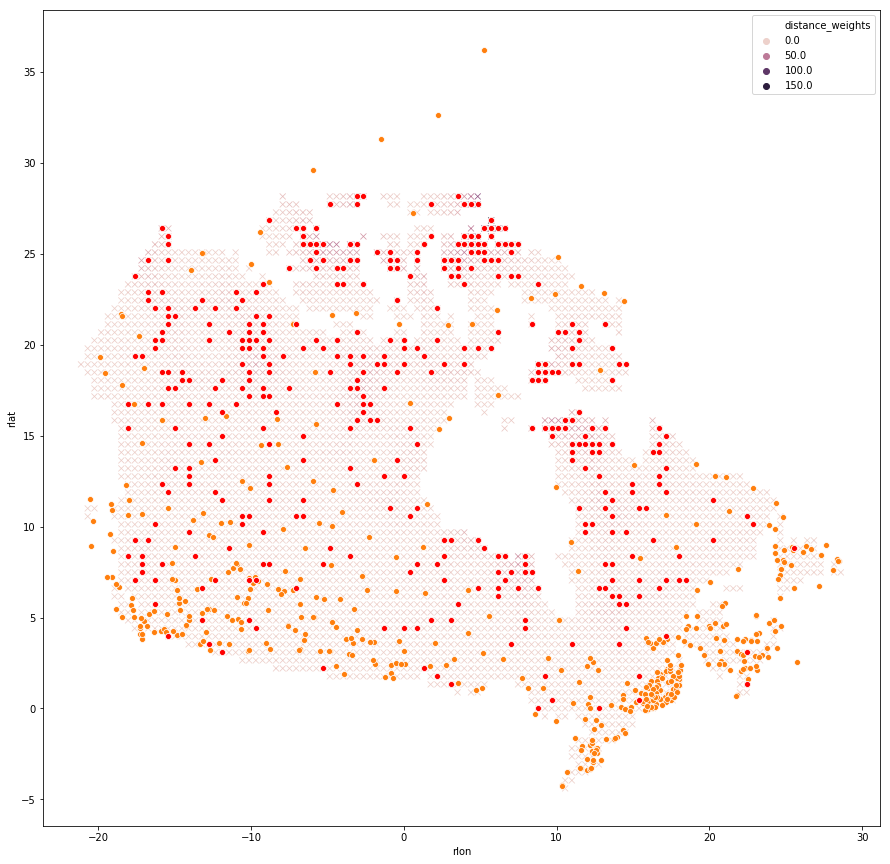

In [126]:
plt.figure(figsize=(15, 15))
sns.scatterplot('rlon', 'rlat', hue='distance_weights', marker='x', data=df_non_stations)
sns.scatterplot('rlon', 'rlat',  marker='o', data=df)
sns.scatterplot('rlon', 'rlat', marker='o', color='red', data=df_non_stations_weight)
plt.show()

## Regression Score

Model R2 score: 0.9578125948349081
Model RMSE: 0.06962731901061564
Mean RMSE: 0.01790900779782511


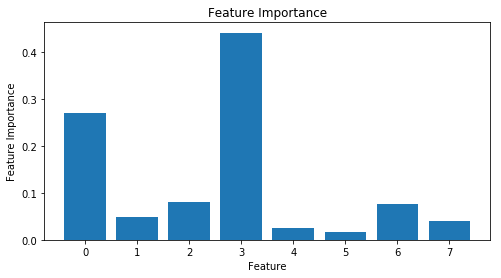

In [127]:
print("Model R2 score:", model.score(X, Y))

# rmse = np.sqrt(mean_squared_error(Y, model.predict(X)))
print("Model RMSE:", rmse)

# rmse_mean = np.sqrt(mean_squared_error(ndf['RL50 (kPa)'].values, mean_values))
print("Mean RMSE:", rmse_mean_sample)

# plots
plt.figure(figsize=(8, 4))
plt.title("Feature Importance")
# tstr = [str(t) for t in tuples]
# plt.bar(tstr, model.feature_importances_)
plt.bar(range(model.feature_importances_.size), model.feature_importances_)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.show()

## Reconstruct the entire field

In [128]:
dc = d_grid[..., 0].flatten().copy()

# d_gridx = np.dstack([d_grid, rlat, rlon])

d_gridx = d_grid
d_gridx = np.delete(d_grid, [2, 5, 10, 11, 12, 13, 14, 15], axis=2)
d_gridx.shape

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


(130, 155, 8)

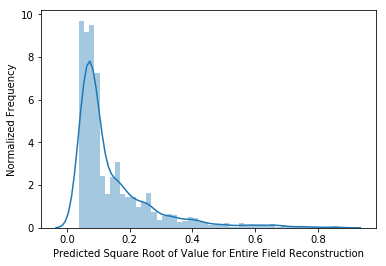

In [129]:
dc[final_mask.flatten()] = model.predict(d_gridx[final_mask])**2
sns.distplot(model.predict(d_gridx[final_mask])**2)
plt.xlabel("Predicted Square Root of Value for Entire Field Reconstruction")
plt.ylabel("Normalized Frequency")
plt.savefig("/home/nannau/Pictures/recondist")
assert np.any(model.predict(d_gridx[final_mask]) < 0.0) == False

In [130]:
dc[~final_mask.flatten()] = np.nan
final = dc.reshape(d_gridx[..., 0].shape)
fff = final_mask
dcb = dc.copy()
dcb[final_mask.flatten()] = model.predict(d_gridx[final_mask]) <= 0.0
dcb = dcb.reshape(final_mask.shape)

assert np.allclose(dcb[final_mask], 0.0)

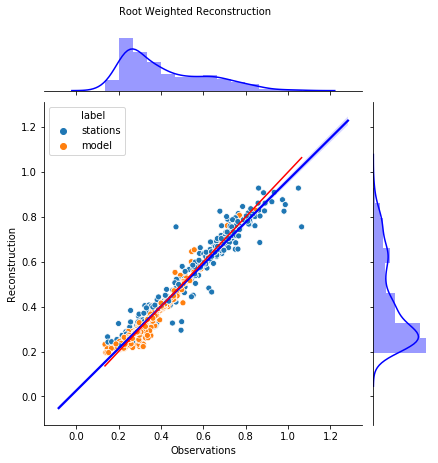

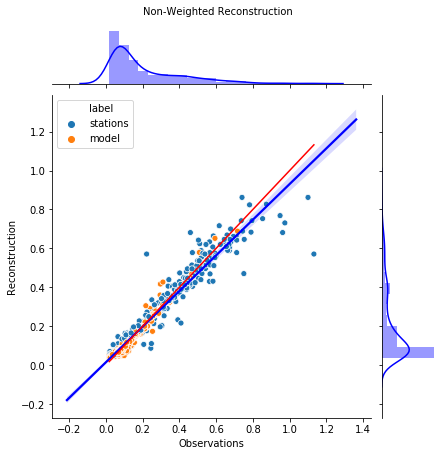

slope of plot 0.9160438835844368 r2_val of plot 0.9439923305108697


In [131]:
sns.jointplot(Y.flatten(), model.predict(X), kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y.flatten(), model.predict(X), hue=ndf.label, marker='o')
sns.lineplot(Y.flatten(), Y.flatten(), color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')
plt.savefig('recon_1:1')
plt.text(0.2, 1.7, "Root Weighted Reconstruction")
plt.show()

sns.jointplot(Y.flatten()**2, model.predict(X)**2, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(Y.flatten()**2, model.predict(X)**2, hue=ndf.label, marker='o')
sns.lineplot(Y.flatten()**2, Y.flatten()**2, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')
plt.text(0.2, 1.8, "Non-Weighted Reconstruction")
plt.savefig('recon_1:1')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(Y.flatten()**2, model.predict(X).flatten()**2)
print("slope of plot", slope, "r2_val of plot", r_value**2)

## Plot the final reconstructed field

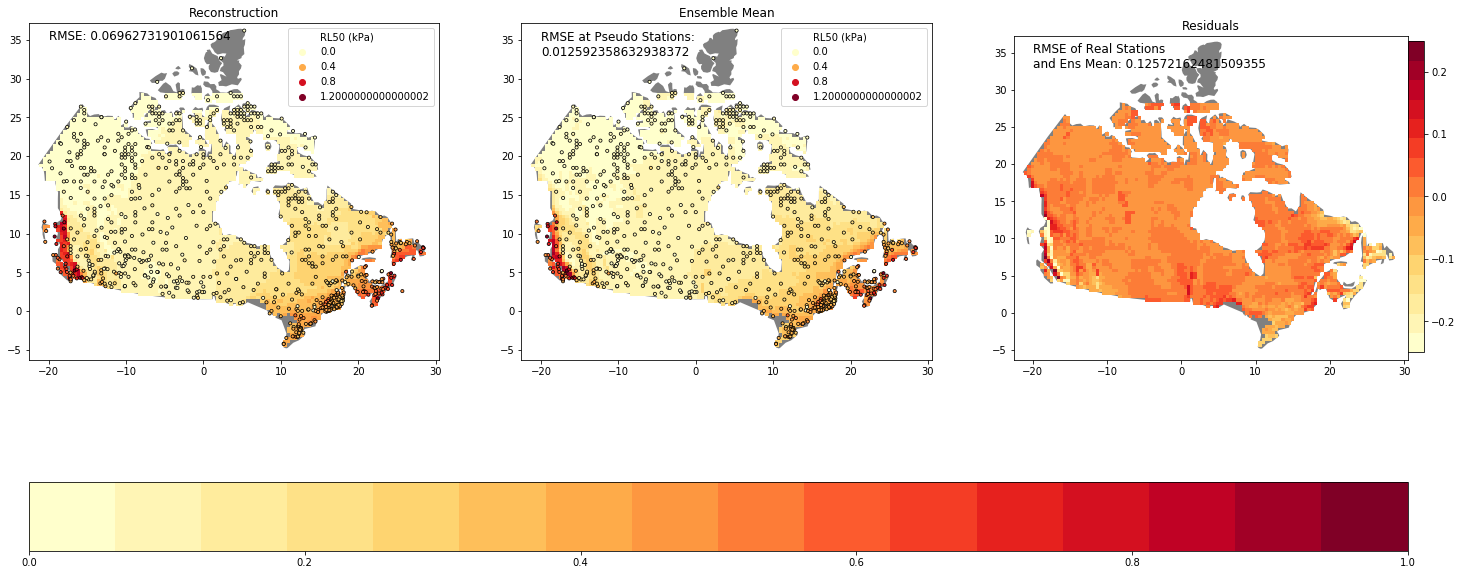

In [132]:
ens_mean_with_nan = ens_mean.copy()
ens_mean_with_nan[~final_mask] = np.nan
ens_mean_with_nan = ens_mean_with_nan.reshape(ens_mean.shape)

fig, ax = plt.subplots(1, 3, figsize=(25, 15))
vmin, vmax = 0.,1.0
canada.plot(ax=ax[0], color='gray', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax[0], palette='YlOrRd', s=10, edgecolor='black', hue_norm=(vmin, vmax))

canada.plot(ax=ax[1], color='gray', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax[1], palette='YlOrRd', s=10, edgecolor='black', hue_norm=(vmin, vmax))

canada.plot(ax=ax[2], color='gray', zorder=0)


img = ax[0].imshow(
        final,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax
)

img1 = ax[1].imshow(
        ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax
)

img2 = ax[2].imshow(
        ens_mean_with_nan-final,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('YlOrRd', 16), vmin=-0.25, vmax=0.25
)

ax[0].set_title("Reconstruction")
ax[0].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[0].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[0].text(-20, 35, "RMSE: {}".format(rmse), fontsize=12, zorder=1)

ax[1].set_title("Ensemble Mean")
ax[1].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[1].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[1].text(-20, 33, "RMSE at Pseudo Stations: \n{}".format(rmse_mean), fontsize=12)

ax[2].set_title("Residuals")
ax[2].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[2].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[2].text(-20, 33, "RMSE of Real Stations \nand Ens Mean: {}".format(rmse_mean_and_stations), fontsize=12)
plt.colorbar(img2, ax=ax[2], orientation='vertical', fraction=0.038, pad=0.001)


fig.colorbar(img1, ax=ax, orientation='horizontal')

## Change the colors to highlight contours

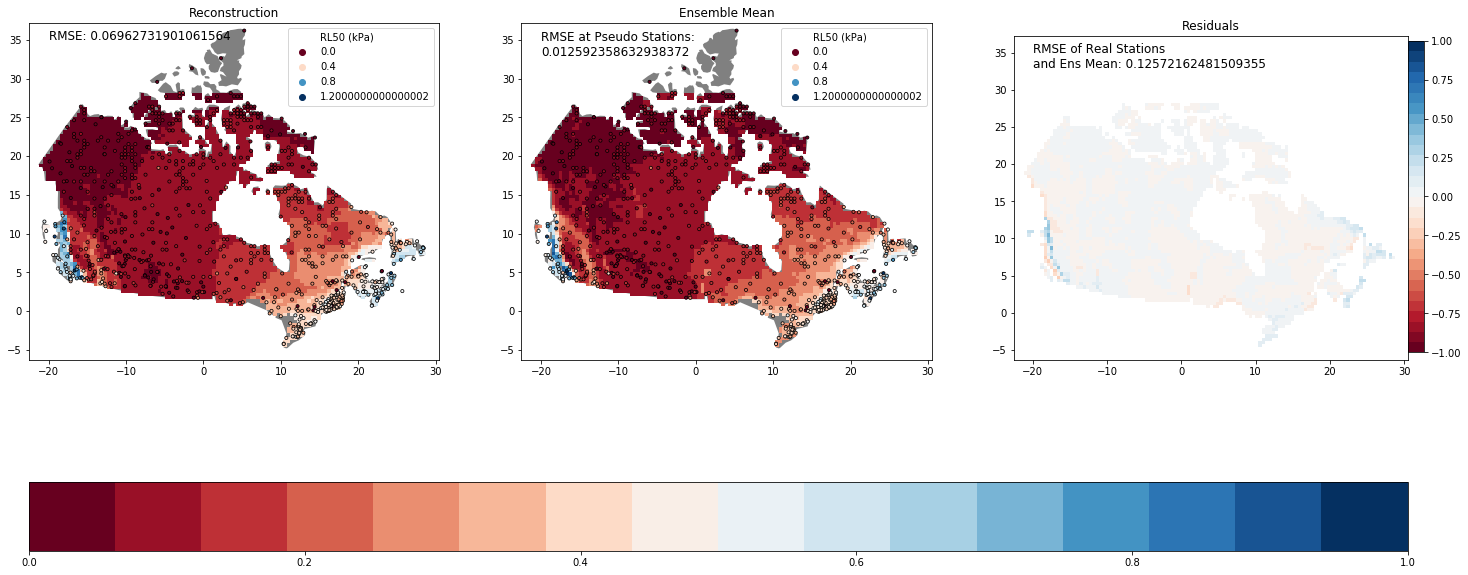

In [133]:
fig, ax = plt.subplots(1, 3, figsize=(25, 15))

canada.plot(ax=ax[0], color='gray', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax[0], palette='RdBu', s=10, edgecolor='black', hue_norm=(vmin, vmax))

canada.plot(ax=ax[1], color='gray', zorder=0)
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax[1], palette='RdBu', s=10, edgecolor='black', hue_norm=(vmin, vmax))

img = ax[0].imshow(
        final,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax
)

img1 = ax[1].imshow(
        ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 16), vmin=vmin, vmax=vmax
)

img2 = ax[2].imshow(
        final-ens_mean_with_nan,
        origin='lower',
        extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
        cmap=plt.get_cmap('RdBu', 30), vmin=-1., vmax=1.
)

ax[0].set_title("Reconstruction")
ax[0].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[0].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[0].text(-20, 35, "RMSE: {}".format(rmse), fontsize=12, zorder=1)

ax[1].set_title("Ensemble Mean")
ax[1].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[1].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[1].text(-20, 33, "RMSE at Pseudo Stations: \n{}".format(rmse_mean), fontsize=12)

ax[2].set_title("Residuals")
ax[2].set_ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
ax[2].set_xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
ax[2].text(-20, 33, "RMSE of Real Stations \nand Ens Mean: {}".format(rmse_mean_and_stations), fontsize=12)
plt.colorbar(img2, ax=ax[2], orientation='vertical', fraction=0.038, pad=0.001)

fig.colorbar(img1, ax=ax, orientation='horizontal')
plt.savefig('synthetic_composite')

## Plot the ensemble mean

## Upscale/Interpolate the final reconstructed field 10 fold

In [134]:
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator

rlon_ens, rlat_ens = flatten_coords(ds.rlon.values, ds.rlat.values, ds)
irlat, irlon = np.linspace(rlat.min(), rlat.max(), rlat.shape[0]*10), np.linspace(rlon.min(), rlon.max(), rlon.shape[1]*10)

x, y = flatten_coords(irlon, irlat, ds)
points = np.array(list(zip(x, y)))
np.array(list(zip(rlon_ens, rlat_ens))), d_grid[final_mask], final[final_mask].flatten()

iff = LinearNDInterpolator(list(zip(rlon_ens, rlat_ens)), final.flatten())
ifinal = iff(points)

In [135]:
# reshape into a grid
ifinal = ifinal.reshape(irlat.shape[0], irlon.shape[0])

## Plot final interpolated field

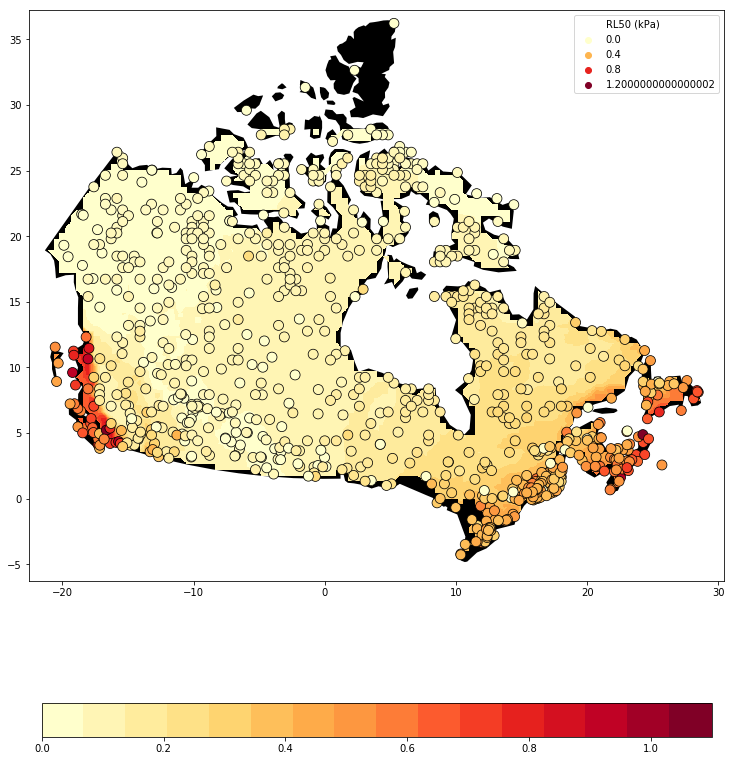

In [136]:
fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
vmin, vmax = 0., 1.1
sns.scatterplot(df.rlon.values, df.rlat.values, hue=df['RL50 (kPa)'], ax=ax, palette='YlOrRd', s=100, edgecolor='black', hue_norm=(vmin, vmax))
img = ax.imshow(ifinal, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax, orientation='horizontal',shrink=0.8)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

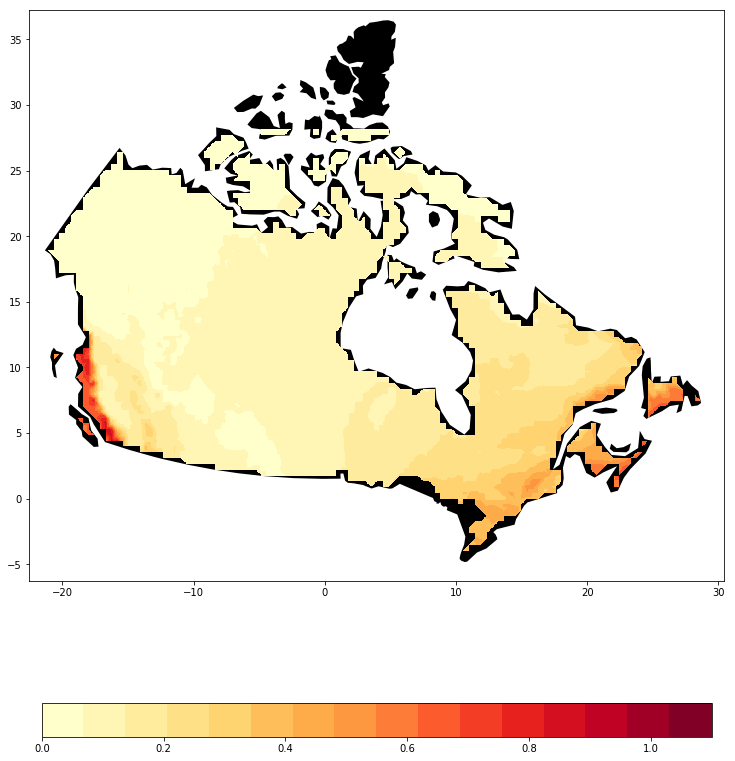

In [137]:
fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
vmin, vmax = 0., 1.1
img = ax.imshow(ifinal, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax, orientation='horizontal',shrink=0.8)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

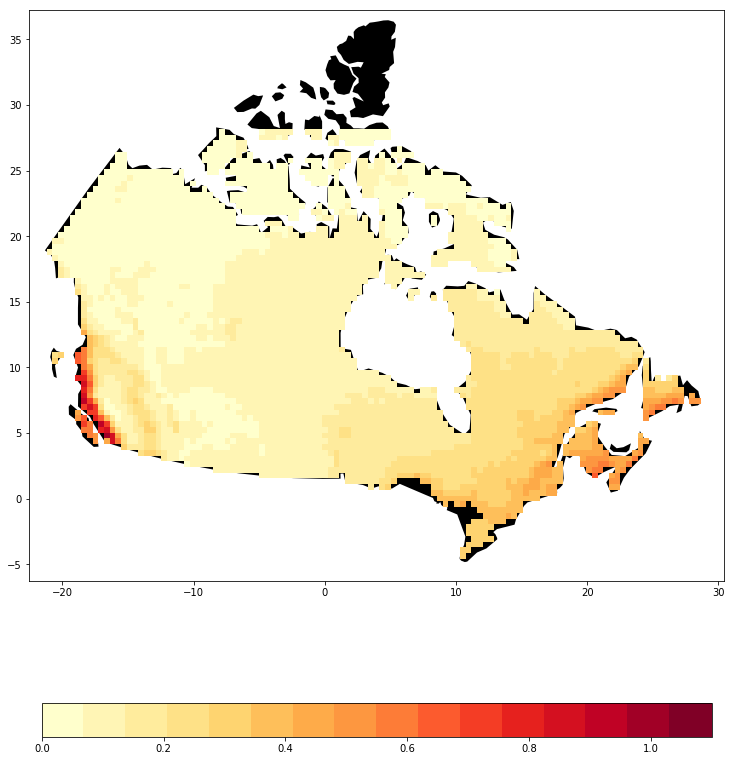

In [138]:
fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
vmin, vmax = 0., 1.1
img = ax.imshow(ens_mean_with_nan, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax, orientation='horizontal',shrink=0.8)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')

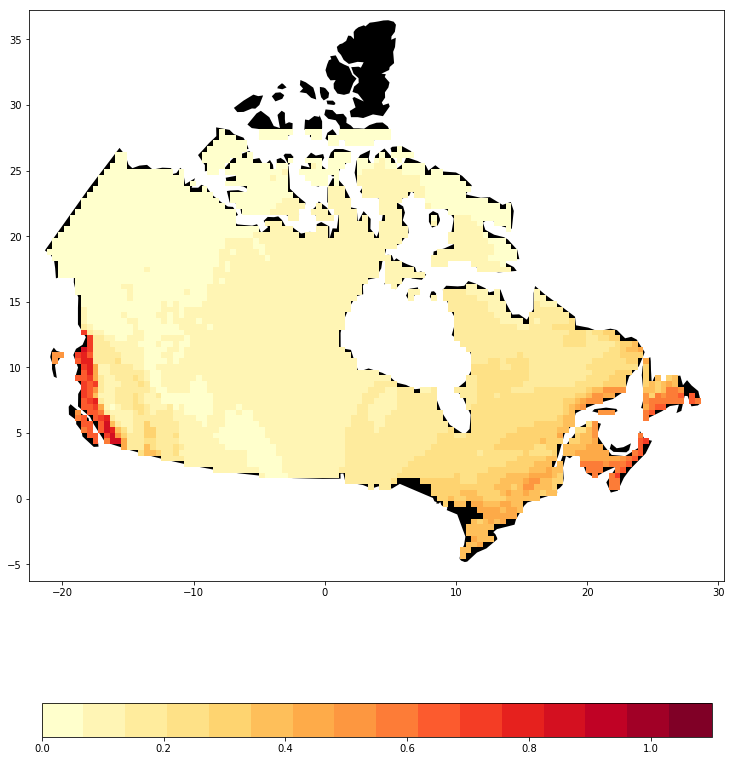

In [139]:
fig, ax = plt.subplots(figsize=(15, 15))

# this plots canada
canada.plot(ax=ax, color='black', zorder=0)
vmin, vmax = 0., .5
vmin, vmax = 0., 1.1
img = ax.imshow(final, origin='lower', extent=[ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(),ds.rlat.values.max()], cmap=plt.get_cmap('YlOrRd', 16), vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax, orientation='horizontal',shrink=0.8)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.savefig('reconstructions')